In [1]:
## TODO: Word2vec and Glove

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from gensim.models import Word2Vec

In [3]:
# df_merged = pd.read_csv("../data/merged_all_datasets.csv")
# df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

# Word2Vec

In [ ]:
# Thomas Mikolov tried to find the meaning of words and how to represent them numerically
# He came up with an idea to train neural network so that words that appear in similar contexts have close vectors
# Word vectors provide semantic meaning of words as vectors based on training corpus
# This algorithm was a great invention that allows to capture analogies 
# (e.g.  king - man + woman = queen or woman + europe + physics + scientist = Marie Curie

# source: Natural Language Processing in Action (book)

In [7]:
# I train Word2Vec on my own data, but the thing is that the articles are general and our corpus is not so huge
# We could use all merged datasets instead of balanced, but still the domain of my data is general
# Hence it would be better idea to just get pre-trained models and get embeddings from it.

In [8]:
# Each article is splitted into tokens (words)
sentences = [sentence.split() for sentence in x_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [9]:
w2v_model.wv

### Exploring the model

In [17]:
w2v_model.wv.most_similar(positive="warning")

[('going', 0.9836194515228271),
 ('out', 0.983172595500946),
 ('its', 0.9830321669578552),
 ('face', 0.9828433990478516),
 ('her', 0.9827855825424194),
 ('president', 0.9827393889427185),
 ('found', 0.9827317595481873),
 ('back', 0.9827278852462769),
 ('video', 0.9827114343643188),
 ('police', 0.9826991558074951)]

In [18]:
w2v_model.wv.most_similar(positive="warns")

[('court', 0.9992703199386597),
 ('top', 0.9991949796676636),
 ('say', 0.9991567134857178),
 ('military', 0.9991048574447632),
 ('South', 0.9990924596786499),
 ('probe', 0.9990585446357727),
 ('would', 0.999024510383606),
 ('U.N.', 0.9990128874778748),
 ('foreign', 0.9990090131759644),
 ('law', 0.9989861845970154)]

In [19]:
w2v_model.wv.most_similar(positive=["car", "vehicle"], topn=5)

[('Iraq', 0.9986475110054016),
 ('opposition', 0.9985900521278381),
 ('show', 0.9985446333885193),
 ('oil', 0.998509407043457),
 ('case', 0.9984796047210693)]

In [20]:
import numpy as np

def create_text_vectors_from_word_embedding_word2vec_model(
    model: gensim.models.keyedvectors.KeyedVectors
    sentence: str
):
    '''
    Function that generates text embedding vector by taking an average of all word embedding vectors. 
    If no words appear in word2vec then algorithm outputs vector of zeros.
    '''
    
    # Split words into on array of words
    words_splitted = sentence.split()
    # For each word in text get its vector representation
    words_vecs = [w2v_model.wv[word] for word in words_splitted if word in w2v_model.wv]
    # If none of this words appear in our word2vec model then its length will be zero and we just create empty array of zeros
    if len(words_vecs) == 0:
        return np.zeros(100)
        
    # otherwise, we just calculate the mean of all these vector representations 
    words_vectors_word2vec = np.array(words_vecs)
    return words_vectors_word2vec.mean(axis=0)

# For each article we get mean vector embedding
x_train_vect = np.array([create_text_vectors_from_word_embedding_word2vec_model(sentence) for sentence in x_train])
x_test_vect = np.array([create_text_vectors_from_word_embedding_word2vec_model(sentence) for sentence in x_test])

In [ ]:
# TODO:
# https://freedium.cfd/https://medium.com/@chandu.bathula16/machine-learning-concept-9-71b6bd2ea77d
# You can try to write algorithm for word2vec + tf-idf weighted. :)
# https://medium.com/analytics-vidhya/featurization-of-text-data-bow-tf-idf-avgw2v-tfidf-weighted-w2v-7a6c62e8b097

## Training models

In [21]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vect, y_train)

RandomForestClassifier(random_state=0)

In [23]:
pred_rf = RF.predict(x_test_vect)

In [24]:
RF.score(x_test_vect, y_test)

0.8565

In [25]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2019
           1       0.86      0.84      0.85      1981

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000



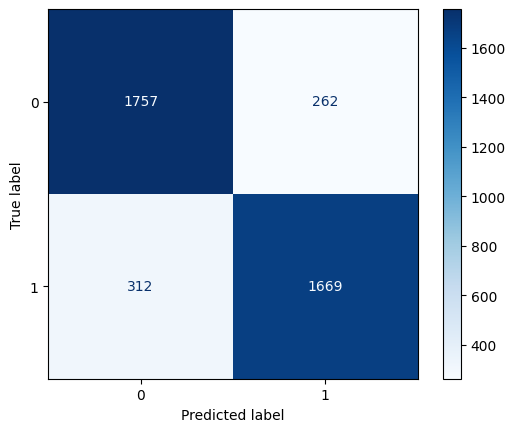

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred_rf)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [27]:
import xgboost as xgb

In [28]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(x_train_vect, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [29]:
pred_xgb = xgb_model.predict(x_test_vect)

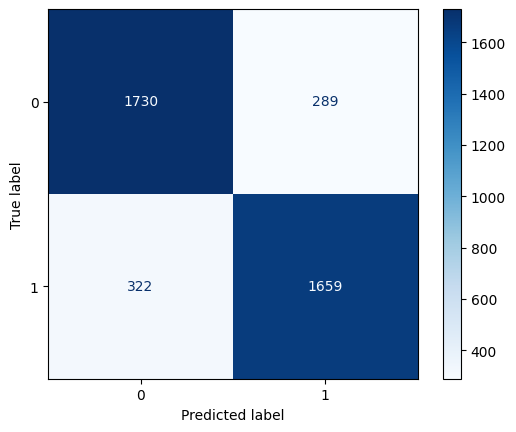

In [30]:
cm = confusion_matrix(y_test, pred_xgb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Using pre-trained word2vec model

In [5]:
import gensim.downloader as api
# Loading already pre-trained model on google news
wv = api.load('word2vec-google-news-300')

In [6]:
wv

In [7]:
ans_vect =  wv['woman'] + wv['Europe'] + wv['physics'] + wv['scientist'] - wv['male'] - 2 * wv['man']
wv.similar_by_vector(ans_vect, topn= 15)

[('physics', 0.6271687150001526),
 ('scientist', 0.6203182339668274),
 ('physicist', 0.5793354511260986),
 ('science', 0.5157865285873413),
 ('geochemist', 0.5141739845275879),
 ('researcher', 0.5038483738899231),
 ('Physicist', 0.5035572648048401),
 ('planetary_scientist', 0.4968586564064026),
 ('Chu_Nobel_laureate', 0.48720353841781616),
 ('geophysicist', 0.48685815930366516),
 ('particle_physicist', 0.4841868281364441),
 ('Physics', 0.4776281416416168),
 ('astrophysics', 0.4745880365371704),
 ('theoretical_astrophysics', 0.4680024981498718),
 ('Scripps_Oceanography', 0.466260701417923)]

In [8]:
wv.most_similar(positive= ["Cristiano_Ronaldo", "science"],negative=["sport"], topn=5)

[('Fernando_Torres', 0.5034375786781311),
 ('Dimitar_Berbatov', 0.4991177022457123),
 ('Ronaldo', 0.49781620502471924),
 ('striker_Fernando_Torres', 0.4968187212944031),
 ('Carlos_Tevez', 0.473631888628006)]

In [27]:
wv.most_similar(positive = ["woman", "sword"], negative = ["man"])

[('swords', 0.6237959861755371),
 ('broadsword', 0.5374425649642944),
 ('scimitar', 0.4882256090641022),
 ('katana', 0.4881975054740906),
 ('knife', 0.48329806327819824),
 ('samurai_sword', 0.4832817614078522),
 ('sandal_flick', 0.47444045543670654),
 ('broadswords', 0.4732465445995331),
 ('crucifix', 0.46822476387023926),
 ('Samurai_sword', 0.4644865095615387)]

In [20]:
wv.most_similar(positive= ["king", "woman"],negative=["man"], topn=2)

[('queen', 0.7118193507194519), ('monarch', 0.6189674139022827)]

In [19]:
wv.similar_by_vector(wv["king"] + wv["woman"] - wv["man"], topn=2)

[('king', 0.8449392318725586), ('queen', 0.7300517559051514)]

In [9]:
import numpy as np

def vectorize_pretrained(sentence):
    words = sentence.split()
    words_vecs = [wv[word] for word in words if word in wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
        # Dimension of embeddings!!!
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

x_train_vect_pretrained = np.array([vectorize_pretrained(sentence) for sentence in x_train])
x_test_vect_pretrained= np.array([vectorize_pretrained(sentence) for sentence in x_test])

In [10]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vect_pretrained, y_train)

RandomForestClassifier(random_state=0)

In [11]:
pred_rf = RF.predict(x_test_vect_pretrained)

In [12]:
RF.score(x_test_vect_pretrained, y_test)

0.921125

In [13]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7979
           1       0.92      0.93      0.92      8021

    accuracy                           0.92     16000
   macro avg       0.92      0.92      0.92     16000
weighted avg       0.92      0.92      0.92     16000



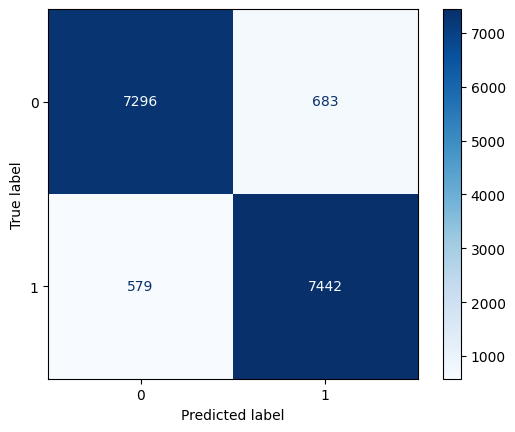

In [16]:
cm = confusion_matrix(y_test, pred_rf)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# The question that appears in my head is that Word2vec is already pretrained, so why we should train it once again?
# The answer is that you can use pre-trained model without fitting it to your data if it is general domain
# Link:
# https://datascience.stackexchange.com/questions/110006/why-we-need-to-train-word2vec-when-word2vec-itself-is-said-to-be-pretrained
# https://datascience.stackexchange.com/questions/92856/the-reason-behind-using-a-pre-trained-model
# https://www.google.com/search?q=usng+pretrained+word2vec+or+not&oq=usng+pretrained+word2vec+or+not&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIJCAEQIRgKGKABMgkIAhAhGAoYoAHSAQgzOTY5ajBqNKgCALACAQ&sourceid=chrome&ie=UTF-8

# Glove

In [ ]:
## TODO: Glove

In [ ]:
embedding_index = {}
# This is reference to local path
# Glove models are huge, so we decided not to store it in github, but on google drive
path_local = r"C:\Users\Mateusz\Desktop\PRACA INZYNIERSKA\glove.6B.100d.txt"
with open(path_local, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs